In [1]:
import micrograd.engine as me
import math
import numpy as np
import matplotlib.pyplot as plt
from value import Value
import graph_plotting as gp
from graphviz import Digraph

%load_ext autoreload
%autoreload 2

## Micrograd example usage

#### Iteration #1

In [2]:
a = me.Value(-4.0)
b = me.Value(2.0)
g = a + b

# prints the outcome of this forward pass
print(f'{g.data:.4f}') 
g.backward()
# prints the numerical value of dg/da
print(f'{a.grad:.4f}') 
# prints the numerical value of dg/db
print(f'{b.grad:.4f}') 

-2.0000
1.0000
1.0000


#### Iteration #2

In [4]:
a = me.Value(-4.0)
b = me.Value(2.0)
c = a + b
c += c + 1
c += 1 + c + (-a)
g = c

# prints the outcome of this forward pass
print(f'g={g.data:.4f}') 
g.backward()
# prints the numerical value of dg/da
print(f'dg/da={a.grad:.4f}') 
# prints the numerical value of dg/db
print(f'dg/da={b.grad:.4f}') 

g=-1.0000
dg/da=3.0000
dg/da=4.0000


In [5]:
c = a + b
print(f'{c.data:.4f}')
c += c + 1
print(f'{c.data:.4f}')
c += 1 + c + (-a)
print(f'{c.data:.4f}')

-2.0000
-3.0000
-1.0000


#### Iteration #3

In [7]:
a = me.Value(-4.0)
b = me.Value(2.0)
c = a + b
c += c + 1
c += 1 + c + (-a)
d = a * b + b ** 3
# print(f'{d.data:.4f}')
d += d * 2 + (b + a).relu()
# print(f'{d.data:.4f}')
d += 3 * d + (b - a).relu()
# print(f'{d.data:.4f}')
g = d

# prints the outcome of this forward pass
print(f'g={g.data:.4f}') 
g.backward()
# prints the numerical value of dg/da
print(f'dg/da={a.grad:.4f}') 
# prints the numerical value of dg/db
print(f'dg/da={b.grad:.4f}') 

g=6.0000
dg/da=23.0000
dg/da=97.0000


#### Iteration #4

In [8]:
a = me.Value(-4.0)
b = me.Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

24.7041
138.8338
645.5773


## Building Micrograd - Part 1

### A few functions

#### A single variable function

In [9]:
def f(x):
  return 3 * x ** 2 - 4 * x + 5

In [10]:
f(1), f(3)

(4, 20)

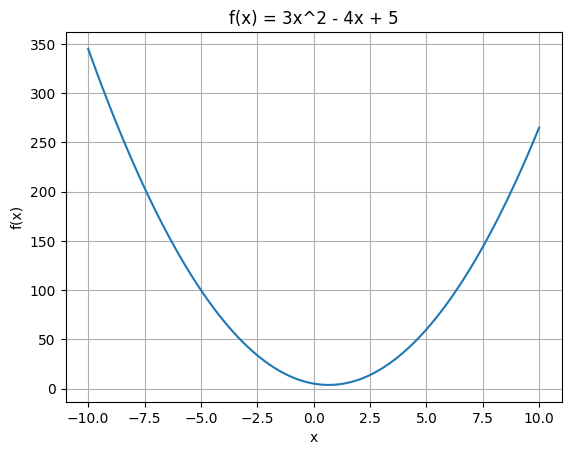

In [11]:
# plot the function f
x = np.linspace(-10, 10, 100)
plt.plot(x, f(x))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('f(x) = 3x^2 - 4x + 5')
plt.grid()

In [12]:
h = 0.000001
x = np.array([-3, 3, 2/3])
(f(x + h) - f(x)) / h

array([-2.19999970e+01,  1.40000030e+01,  2.99937852e-06])

#### Multiple variable function

In [13]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [14]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


### Building `Value` class step-by-step

#### Addition and Multiplication

In [15]:
a, b, c = Value(2.0), Value(-3.0), Value(10.0)
d = a * b + c

In [16]:
d, d._prev, d._op

(Value(data=4.0, grad=0),
 {Value(data=-6.0, grad=0), Value(data=10.0, grad=0)},
 '+')

#### DAG plotting

In [17]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0, grad=0)

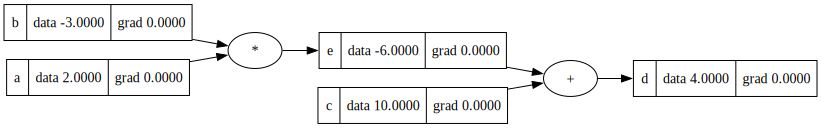

In [18]:
gp.draw_dot(d)  

#### Gradient estimation

In [41]:
def lol():
  
    h = 0.001

    aa = Value(2.0, label='a')
    bb = Value(-3.0, label='b')
    cc = Value(10.0, label='c')
    ee = aa * bb; ee.label = 'e'
    dd = ee + cc; dd.label = 'd'
    ff = Value(-2.0, label='f')
    LL = dd * ff; LL.label = 'L'
    L1 = LL.data

    aa = Value(2.0, label='a')
    bb = Value(-3.0+h, label='b')
    cc = Value(10.0, label='c')
    ee = aa * bb; ee.label = 'e'; 
    dd = ee + cc; dd.label = 'd'
    ff = Value(-2.0, label='f')
    LL = dd * ff; LL.label = 'L'
    L2 = LL.data

    print((L2 - L1)/h)

In [42]:
lol()

-3.9999999999995595


#### Manual gradient backprop

In [23]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0, grad=0)

In [43]:
L.grad = 1.0
d.grad = f.data * L.grad
f.grad = d.data * L.grad
e.grad = d.grad
c.grad = d.grad
b.grad = e.grad * a.data
a.grad = e.grad * b.data


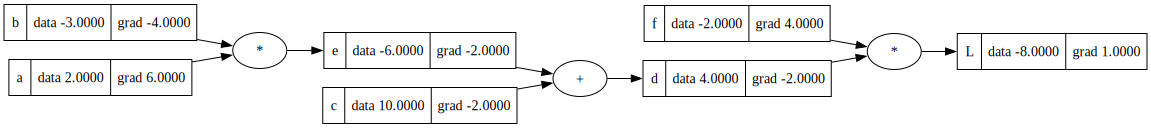

In [44]:
gp.draw_dot(L) 